In [1]:
import numpy as np
import matplotlib.pyplot as plt
from spm.spm import spm_cat
from utility.math_utils import nat_log, dic2mat

np.set_printoptions(precision = 4)


Posterior over states q(s) in example 1:

[[0.9878 0.9878]
 [0.0122 0.0122]]


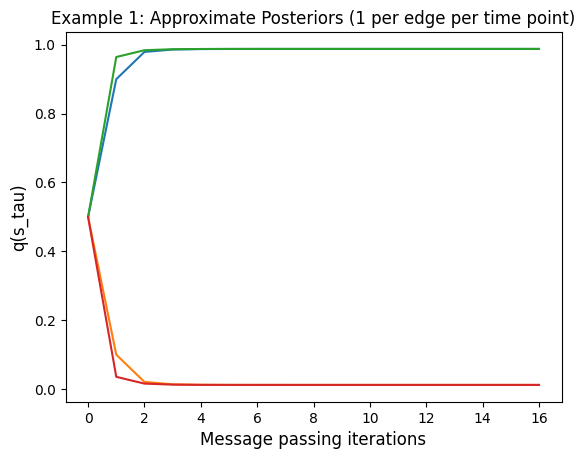

In [3]:
# example 1

# 设置随机种子
np.random.seed()

# priors
D = np.array([0.5, 0.5])

# likelihood mapping
A = np.array([[0.9, 0.1],
              [0.1, 0.9]])

# transitions
B = np.array([[1, 0],
              [0, 1]])

# number of timesteps
T = 2

# number of iterations of message passing
NumIterations = 16

# initialize posterior (Step 1)
Qs = np.zeros((2, T))
for t in range(T):
    Qs[:, t] = np.array([0.5, 0.5])

# fix observations (Step 2)
o = [np.array([1, 0]), np.array([1, 0])]

# iterate a set number of times (alternatively, until convergence) (Step 8)
qs = np.zeros((NumIterations, 2, T))
for Ni in range(NumIterations):
    # For each edge (hidden state) (Step 7)
    for tau in range(T):
        # choose an edge (Step 3)
        q = np.log(Qs[:, tau])
        
        # compute messages sent by D and B (Steps 4) using the posterior
        # computed in Step 6B
        if tau == 0:  # first time point
            lnD = np.log(D)                # Message 1
            lnBs = np.log(B.T @ Qs[:, tau + 1])  # Message 2
        elif tau == T - 1:  # last time point
            lnBs = np.log(B @ Qs[:, tau - 1])  # Message 1
        
        # likelihood (Message 3)
        lnAo = np.log(A.T @ o[tau])
        
        # Steps 5-6 (Pass messages and update the posterior)
        # Since all terms are in log space, this is addition instead of
        # multiplication. This corresponds to equation 16 in the main
        # text (within the softmax)
        if tau == 0:
            q = 0.5 * lnD + 0.5 * lnBs + lnAo
        elif tau == T - 1:
            q = 0.5 * lnBs + lnAo
        
        # normalize using a softmax function to find posterior (Step 6A)
        Qs[:, tau] = np.exp(q) / np.sum(np.exp(q))
        qs[Ni, :, tau] = Qs[:, tau]  # store value for each iteration

Qs  # final posterior beliefs over states

print('\nPosterior over states q(s) in example 1:\n')
print(Qs)


# firing rates (traces)
qs_plot_0 = np.vstack([D, qs[:, :, 0]])  # add prior to starting value
plt.plot(qs_plot_0)
qs_plot_1 = np.vstack([D, qs[:, :, 1]])  
plt.plot(qs_plot_1)
plt.title('Example 1: Approximate Posteriors (1 per edge per time point)')
plt.ylabel('q(s_tau)', fontsize=12)
plt.xlabel('Message passing iterations', fontsize=12)
plt.show()

Posterior over states q(s) in example 2:
[[0.9878 0.9878]
 [0.0122 0.0122]]


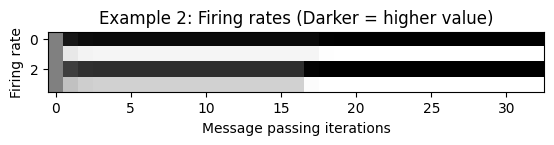

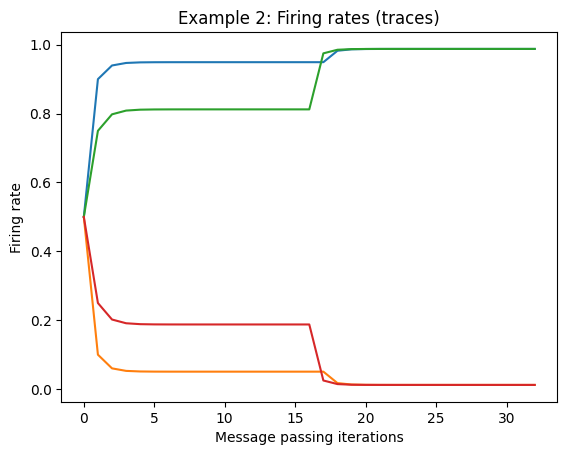

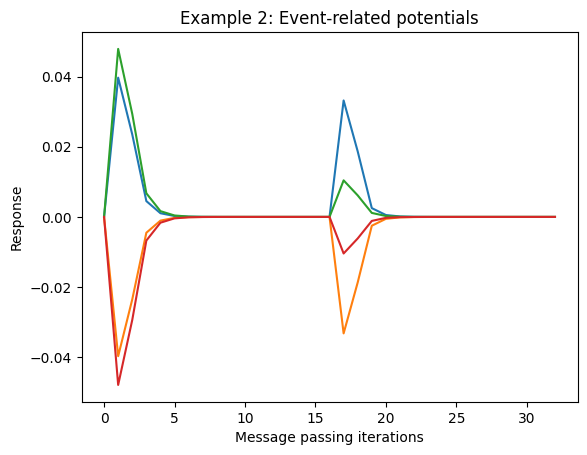

In [5]:
# Example 2
np.random.seed()

D = np.array([.5, .5])

A = np.array([[.9, .1],
              [.1, .9]])

B = np.array([[1, 0],
              [0, 1]])

T = 2
NumIterations = 16

Qs = np.zeros((2, T))
for t in range(T):
    Qs[:, t] = np.array([.5, .5])

o = {}
o[(1, 1)] = [1, 0]
o[(1, 2)] = [0, 0]
o[(2, 1)] = [1, 0]
o[(2, 2)] = [1, 0]

xn = np.zeros((NumIterations, 2, T, T))
epsilon = np.zeros((2, NumIterations, T, T))
for t in range(1, T + 1):
    for Ni in range(NumIterations):
        for tau in range(1, T + 1):
            v = nat_log(Qs[:, t - 1])
            if tau == 1:
                lnD = nat_log(D)
                lnBs = nat_log(B.T @ Qs[:, tau])
            elif tau == T:
                lnBs = nat_log(B @ Qs[:, tau - 2])
            lnAo = nat_log(A.T @ o[(t, tau)])
            if tau == 1:
                epsilon[:, Ni, t - 1, tau - 1] = .5 * lnD + .5 * lnBs + lnAo - v
            elif tau == T:
                epsilon[:, Ni, t - 1, tau - 1] = .5 * lnBs + lnAo - v
            v = v + epsilon[:, Ni, t - 1, tau - 1]
            Qs[:, tau - 1] = np.exp(v) / np.sum(np.exp(v))
            xn[Ni, :, tau - 1, t - 1] = Qs[:, tau - 1]

print('Posterior over states q(s) in example 2:')
print(Qs)

num_states = 2
num_epochs = 2
time_tau = np.array([[1, 2, 1, 2],
                     [1, 1, 2, 2]])

firing_rate = {}
ERP = {}
for t_tau in range(time_tau.shape[1]):
    for epoch in range(num_epochs):
        firing_rate[(epoch, t_tau)] = xn[:, time_tau[0, t_tau] - 1, time_tau[1, t_tau] - 1, epoch].T
        ERP[(epoch, t_tau)] = np.gradient(firing_rate[(epoch, t_tau)], axis=0)

for key in firing_rate:
    firing_rate[key] = np.expand_dims(firing_rate[key], axis=1)

firing_rate = spm_cat(firing_rate)

# 计算全矩阵的大小
max_row = max(key[0] for key in firing_rate) + 1
max_col = max(key[1] for key in firing_rate) + 1

firing_rate = dic2mat(firing_rate)
firing_rate = np.hstack((np.tile(D, (2, 1)).reshape(len(D) * T, 1), firing_rate))

ERP = spm_cat(ERP)
ERP = dic2mat(ERP)
ERP = ERP.T
ERP = np.vstack((np.zeros((1, len(D) * T)), ERP))  # add 0 for starting value

plt.figure()
plt.imshow(64 * (1 - firing_rate), cmap='gray')
plt.title('Example 2: Firing rates (Darker = higher value)')
plt.ylabel('Firing rate')
plt.xlabel('Message passing iterations')
plt.show()

plt.figure()
plt.plot(firing_rate.T)
plt.title('Example 2: Firing rates (traces)')
plt.ylabel('Firing rate')
plt.xlabel('Message passing iterations')
plt.show()

plt.figure()
plt.plot(ERP)
plt.title('Example 2: Event-related potentials')
plt.ylabel('Response')
plt.xlabel('Message passing iterations')
plt.show()

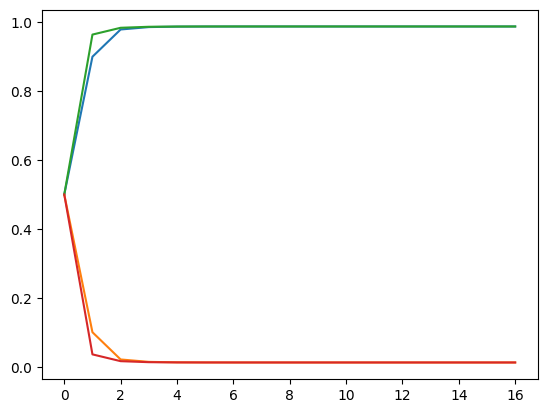

In [34]:
aa = np.vstack([D, qs[:, :, 0]])
bb = np.vstack([D, qs[:, :, 1]])
plt.plot(aa)
plt.plot(bb)

---

以下为Matlab运行结果作为对比：

Example 1的运行结果：

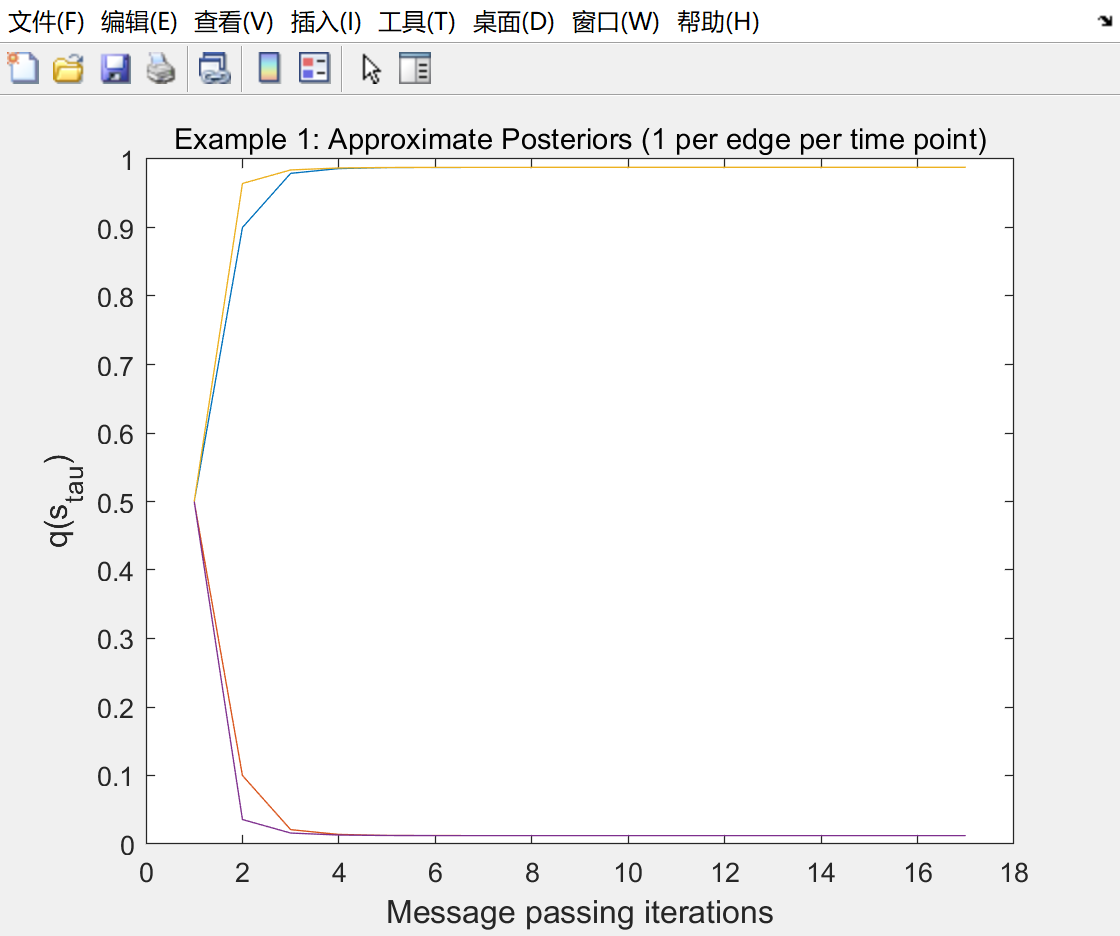

Example 2的运行结果：

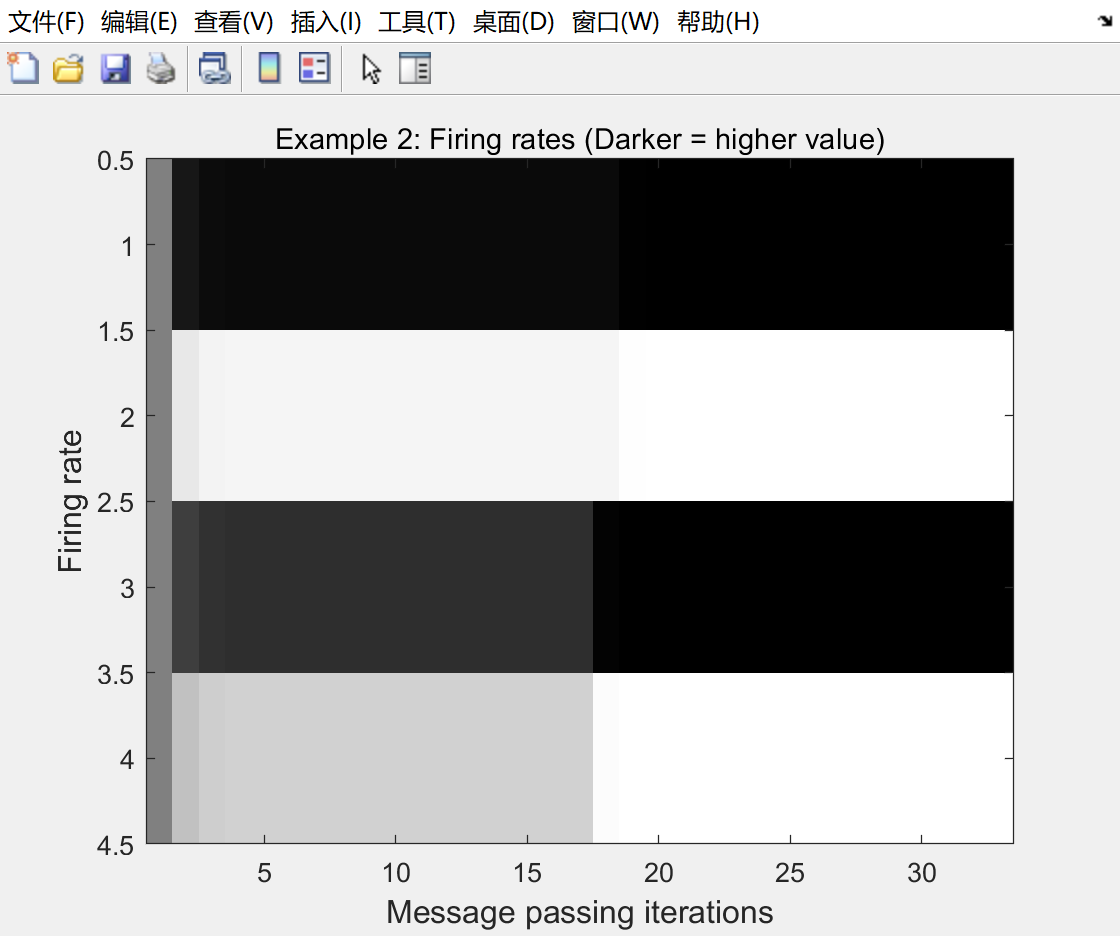

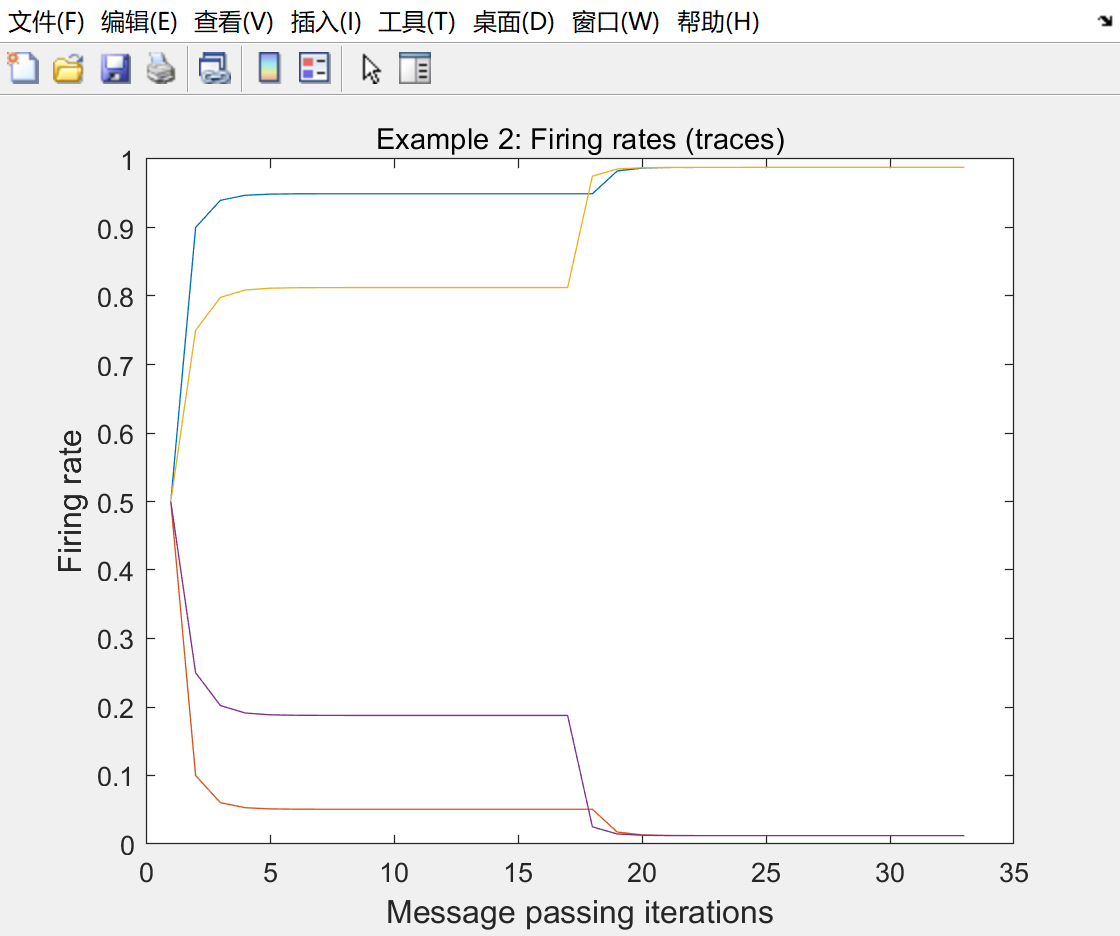

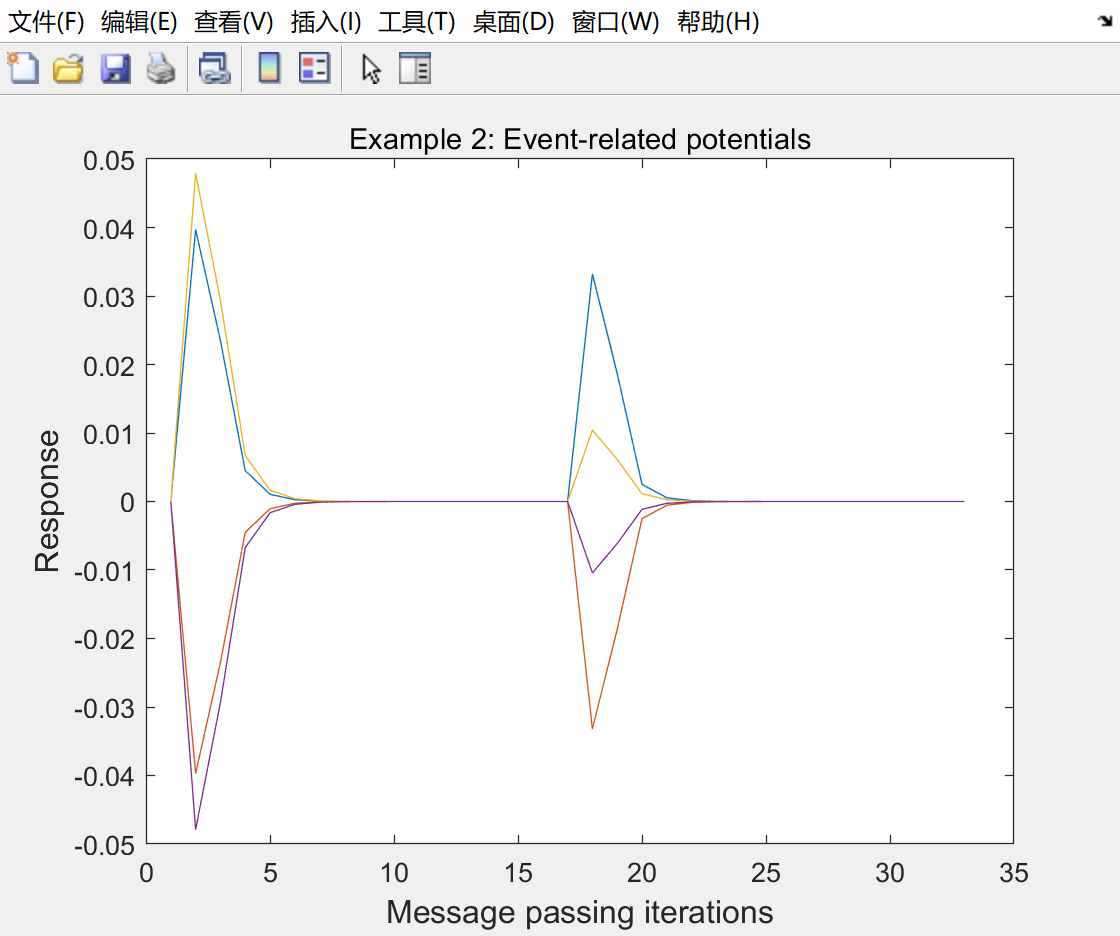